# Program - Print out and Plot profiles in SCM

**Content:**
- Plot profiles in SCM
- Print out profiles in SCM

**Author**: Yi-Hsuan Chen (yihsuan@umich.edu)

In [81]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import io, os, sys, types

import yhc_module as yhc

xr.set_options(keep_attrs=True)  # keep attributes after xarray operation

## Functions

### read_scm_ds

In [83]:
def read_scm_ds(choice):

    if ( choice == "RF01_modIOP_psflx" ):
        datapath = "/lfs/home/yihsuanc/data/data.TaiESM1_scm/scm_taiesm1/scm_taiesm1.dycomsrf01.psflx.0506155039/run/"
    elif ( choice == "RF01_modIOP_isflx" ):
        datapath = "/lfs/home/yihsuanc/data/data.TaiESM1_scm/scm_taiesm1/scm_taiesm1.dycomsrf01.isflx.0506155912/run/"
    elif ( choice == "RF02_modIOP_psflx" ):
        datapath = "/lfs/home/yihsuanc/data/data.TaiESM1_scm/scm_taiesm1/scm_taiesm1.dycomsrf02.psflx.0506161739/run/"
    elif ( choice == "RF02_modIOP_isflx" ):
        datapath = "/lfs/home/yihsuanc/data/data.TaiESM1_scm/scm_taiesm1/scm_taiesm1.dycomsrf02.isflx.0506160923/run/"
    else:
      error_msg = f"ERROR: does not suppoer [{choice}]"
      raise ValueError(error_msg)

    #--- single file
    filename_scm = "camrun.cam.h0.1999-07-11-00000.nc"
    file_scm = datapath+"/"+filename_scm

    ds_scm = xr.open_dataset(file_scm) 
    return ds_scm

#-----------
# do_test
#-----------

#do_test="t1"
do_test="none"

if (do_test == "t1"):
    choice = "RF01_modIOP_psflx"
    ds_scm = read_scm_ds(choice)

    ds_scm

### plot_scm_profiles_1vNt

In [84]:
def plot_scm_profiles_1vNt (ds, variable_names, 
                            tt1=0, tt2=6, jj=0, ii=0, ylim_p=[1000,850], xlim=None,
                            title = "TaiESM1 SCM RF01 :", 
                            do_units=True):
    """
    ----------------------
    Description:
      Given a SCM dataset and variable names, plot the time steps for each variable

    Input arguments:
      ds: a Xarray Dataset
      variable_names: a list containing the variables in the ds
      tt1, tt2: plot the time indexes from tt1 to tt2
      jj, ii: indexes for lat and lon, respectively
      ylim_p: upper and lower limit of y axis
      xlim  : upper and lower limit of each variable
      title : title on each plot
      do_units: do unit conversion using yhc.unit_convert
    
    Return:
      a plot

    Example:
      import yhc_module as yhc
      
      ttend_min=-100 ; ttend_max=300

      xlim_custom = {
            "T": [283, 295],
            "TTEND_TOT": [ttend_min, ttend_max], "MACPDT": [ttend_min, ttend_max], "MPDT": [ttend_min, ttend_max], 
                    }
      plot_scm_profiles_1vNt(ds_scm, ['T','TTEND_TOT','MACPDT','MPDT'], xlim=xlim_custom)

    Date created: 2024-04-18
    ----------------------
    """
    fig, axes = plt.subplots(1, len(variable_names), figsize=(4*len(variable_names), 4))

    for i, var_name in enumerate(variable_names):
        ds1 = yhc.diagnose_var(ds, [var_name])  # pass var_name as a list, otherwise it will read the first character
        var_data = ds1[var_name][tt1:tt2, :, jj, ii]
        if (do_units): var_data = yhc.unit_convert(var_data)
        units = var_data.attrs['units']
        
        ax = axes[i]

        if xlim is not None and var_name in xlim and xlim[var_name] is not None:
            xlim_var = xlim[var_name]
        else:    
            xlim_var = None
        
        var_data.plot.line(ax=ax, y='lev', yincrease=False, ylim=ylim_p, xlim=xlim_var, marker='o', markersize=4)
        
        ax.grid(True)
        ax.minorticks_on() 
        ax.grid(which='major', color='gray', linestyle='-.', linewidth=0.5)        # set both X and Y grids
        ax.set_title(f"{title} {var_name}")
        ax.set_ylabel("Nominal Pressure (hPa)")
    
    plt.tight_layout()
    plt.show()

#========

ttend_min=-100 ; ttend_max=300
tmin=282 ; tmax=295

xlim_custom = {
    "T": [tmin,tmax], "TBP": [tmin,tmax],  "TAP": [tmin,tmax], 
    "TTEND_TOT": [ttend_min, ttend_max], "MACPDT": [ttend_min, ttend_max], "MPDT": [ttend_min, ttend_max], "DTCORE": [ttend_min, ttend_max],
    
}
#plot_scm_profiles_1vNt(ds_scm, ['TBP','TAP', 'TTEND_TOT', 'DTCORE'], tt2=5, xlim=xlim_custom)
#plot_scm_profiles_1vNt(ds_scm, ['T','TTEND_TOT','MACPDT','MPDT'], xlim=xlim_custom)
#plot_scm_variables(ds_scm, ['Q','QVTEND_TOT'], xlim=xlim_custom)
#plot_scm_variables(ds_scm, ['CLDLIQ','QLTEND_TOT'], xlim=xlim_custom)


### plot_scm_profiles_Nv1t

In [85]:
#####################
#####################
#####################
def set_profile_varnames (opt):
    """
    ----------------------
    Description:
       Return a dictionary variable that can be used in the function, plot_ds_var_profiles

    Input arguments:
       opt (str): option. Currently supported: [DT_budget, DQV_budget, DQL_budget, DQI_budget]

    Return:
       varnames (a dict)

    Example:
      import yhc_module as yhc
      varnames = set_profile_varnames('DT_budget')

    Date created: 2024-03-20
    ----------------------
    """

    func_name = "set_profile_varnames"

    #--- colors for each process
    color_tot = 'black' ; color_dyn = 'darkgray' ; color_PT = 'red' ; color_sum = color_PT
    color_ZM = 'blue'   ; color_CMF = 'cyan'     ; color_DPDLF = 'royalblue' ; color_SHDLF = 'skyblue'
    color_MACP = 'green' ; color_MP = 'limegreen' ; color_QRL = 'orange' ; color_QRS = 'pink' ; 
    color_vdiff = 'purple' ; color_gwd = 'yellow'
    
    #@@@@@@@@@@@@@@@@@
    if (opt == "DT_budget"):
        varnames = {
            'TTEND_TOT': {'color':color_tot, 'label': 'Total=dyn+phys [TTEND_TOT]'},
            'DTCORE': {'color':color_dyn, 'label': 'Dynamics [DTCORE]'},
            'PTTEND': {'color':color_PT, 'label': 'All phys [PTTEND]'},
            'DT_deep': {'color': color_ZM, 'label':'Deep convection [ZMDT+ZMMTT+EVAPTZM]'},
            'CMFDT': {'color': color_CMF, 'label': 'Shallow convection [CMFDT]'},
            'DPDLFT': {'color':color_DPDLF, 'label': 'Deep conv detrain [DPDLFT]'},
            'SHDLFT': {'color':color_SHDLF, 'label':'Shallow conv detrain [SHDLFT]'},
            'MACPDT': {'color':color_MACP, 'label':'Macrophysics [MACPDT]'},
            'MPDT': {'color':color_MP, 'label':'Microphysics [MPCT]'},
            'QRL': {'color':color_QRL, 'label': 'LW radiation [QRL]'},
            'QRS': {'color':color_QRS, 'label':'SW radiation [QRS]'},
            'DTV': {'color':color_vdiff, 'label': 'PBL & turbulence [DTV]'},
            'TTGWORO': {'color':color_gwd, 'label':'grav wave drag [TTGWORO]'},
            'DT_SUM_PHYS': {'color':color_sum, 'label': 'Sum of all phys tend', 'linestyle':'--'},
        }

    #@@@@@@@@@@@@@@@@@
    elif (opt == "DQV_budget"):        
        varnames = {
            'PTEQ': {'color':color_PT, 'label': 'All phys [PTEQ]'},
            'DQV_deep': {'color': color_ZM, 'label':'Deep convection [ZMDQ+EVAPQZM]'},
            'CMFDQ': {'color': color_CMF, 'label': 'Shallow convection [CMFDQ]'},
            'MACPDQ': {'color':color_MACP, 'label':'Macrophysics [MACPDQ]'},
            'MPDQ': {'color':color_MP, 'label':'Microphysics [MPDQ]'},
            'VD01': {'color':color_vdiff, 'label': 'PBL & turbulence [VD01]'},
            'DQV_SUM_PHYS': {'color':color_sum, 'label': 'Sum of all phys tend', 'linestyle':'--'},
        }

    #@@@@@@@@@@@@@@@@@
    elif (opt == "DQL_budget"):           
        varnames = {
            'PTECLDLIQ': {'color':color_PT, 'label': 'All phys [PTECLDLIQ]'},
            'ZMDLIQ': {'color': color_ZM, 'label':'Deep convection [ZMDLIQ]'},
            'CMFDLIQ': {'color': color_CMF, 'label': 'Shallow convection [CMFDLIQ]'},
            'DPDLFLIQ': {'color':color_DPDLF, 'label': 'Deep conv detrain [DPDLFLIQ]'},
            'SHDLFLIQ': {'color':color_SHDLF, 'label':'Shallow conv detrain [SHDLFLIQ]'},
            'MACPDLIQ': {'color':color_MACP, 'label':'Macrophysics [MACPDLIQ]'},
            'MPDLIQ': {'color':color_MP, 'label':'Microphysics [MPDLIQ]'},
            'VDCLDLIQ': {'color':color_vdiff, 'label': 'PBL & turbulence [VDCLDLIQ]'},
            'DQL_SUM_PHYS': {'color':color_sum, 'label': 'Sum of all phys tend', 'linestyle':'--'},
        }

    #@@@@@@@@@@@@@@@@@
    elif (opt == "DQI_budget"):   
        varnames = {
            'PTECLDICE': {'color':color_PT, 'label': 'All phys [PTECLDICE]'},
            'ZMDICE': {'color': color_ZM, 'label':'Deep convection [ZMDICE]'},
            'CMFDICE': {'color': color_CMF, 'label': 'Shallow convection [CMFDICE]'},
            'DPDLFICE': {'color':color_DPDLF, 'label': 'Deep conv detrain [DPDLFICE]'},
            'SHDLFICE': {'color':color_SHDLF, 'label':'Shallow conv detrain [SHDLFICE]'},
            'MACPDICE': {'color':color_MACP, 'label':'Macrophysics [MACPDICE]'},
            'MPDICE': {'color':color_MP, 'label':'Microphysics [MPDICE]'},
            'VDCLDICE': {'color':color_vdiff, 'label': 'PBL & turbulence [VDCLDICE]'},
            'DQI_SUM_PHYS': {'color':color_sum, 'label': 'Sum of all phys tend', 'linestyle':'--'},
        }

    #@@@@@@@@@@@@@@@@@
    else:
        error_msg = f"ERROR: function [{func_name}] does not support [{opt}]."
        raise ValueError(error_msg)


    return varnames

#####################
#####################
#####################
def plot_scm_profiles_Nv1t(ds, varnames,
                      tt=5, jj=0, ii=0, 
                      title = "TaiESM1 SCM TWPICE", xlabel = "VAR", yvar = 'lev', ylabel = "Nominal Pressure (hPa)",
                      do_units=True):
    """
    ----------------------

    Plot variables from an xarray dataset with yvar on the Y axis.

    Parameters:
    - ds (xarray.Dataset): The dataset containing the variables.
    - varnames (dict): A dictionary mapping variable names to styles, including colors, linestyles, and labels.
    - tt, jj, ii: indexes for time, lat, lon, respectively
    
    Returns:
    - A plot

    Example:
      import yhc_module as yhc

      Ex 1:
      ds_scm = xr.open_dataset(file_scm)
      varnames = set_profile_varnames('DT_budget')
      tt=8
      plot_scm_profiles_Nv1t (ds_scm, varnames, tt=tt, xlabel="Temperature tendency")

      Ex 2:
      varnames = {
              'CLDLIQ': {'color': 'red', 'linestyle': '-', 'label': 'CLDLIQ'},
              'CLDICE': {'color': 'blue', 'linestyle': '-'},
                 }
      tt=0
      plot_scm_profiles_Nv1t (ds_scm, varnames, tt=tt, xlabel="")


      jj=0
      ii=0
      yhc.print_1d_arrays(
          ds_scm.ZMDT[tt,:,jj,ii],
          ds_scm.CMFDT[tt,:,jj,ii],
                         )
    Date created: 2024-03-21
    ----------------------
    """

    # Plot each variable
    for var_name, style in varnames.items():

        #--- get variable
        ds = yhc.diagnose_var(ds, [var_name])  # pass var_name as a list, otherwise it will read the first character
        var_data = ds[var_name].isel(time=tt, lat=jj, lon=ii)
        if (do_units): var_data = yhc.unit_convert(var_data)
        units = var_data.attrs['units']
        
        #--- lev
        lev = ds[yvar]

        # If 'label' is not provided in styles, set label as var_name
        label = style.get('label', var_name)
        marker_default = 'o'
        linestyle_default = '-'
        
        # Plot the variable with style
        plt.plot(var_data, lev, label=label, color=style.get('color', 'blue'), linestyle=style.get('linestyle', linestyle_default), marker=marker_default, markersize=4)

    # Add labels and legend

    #--- title and x & y labels
    plt.xlabel(f"{xlabel} ({units})")
    plt.ylabel(ylabel)
      #lat_formatted = "{:.2f}".format(ds['lat'][jj].values)
      #lon_formatted = "{:.2f}".format(ds['lon'][ii].values)
      #plt.title(f"{title}, time step = {tt}, lat={lat_formatted}, lon={lon_formatted}")
    plt.title(f"{title}, time step = {tt}", y=1.1)
    plt.title(f"{xlabel}", loc='left', y=1.001, fontsize = 10)
    plt.title(f"{units}", loc='right', y=1.001, fontsize = 10)

    #--- legend
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

    #--- grids and axises
    plt.grid(True, color='gray', linestyle='--')
    plt.gca().invert_yaxis()
    plt.minorticks_on()

    plt.show()

#----------
# do test
#----------

#do_test="test1_scm"
do_test="xxx"

if (do_test == "test1_scm"):

    datapath = "/lfs/home/yihsuanc/test/c1-scam-tendencies/"
    filename_scm = "camrun.cam.h0.2006-01-17-10800.nc"
    file_scm = datapath+"/"+filename_scm
    ds_scm = xr.open_dataset(file_scm)

    varnames = set_profile_varnames('DT_budget')
    tt=8
    plot_ds_var_profiles (ds_scm, varnames, tt=tt, xlabel="Temperature tendency")

    jj=0
    ii=0
    yhc.print_1d_arrays(
        ds_scm.ZMDT[tt,:,jj,ii],
        ds_scm.CMFDT[tt,:,jj,ii],
                       )

## Plot

### 1vNt: T, TBP, TAP, TTEND_TOT

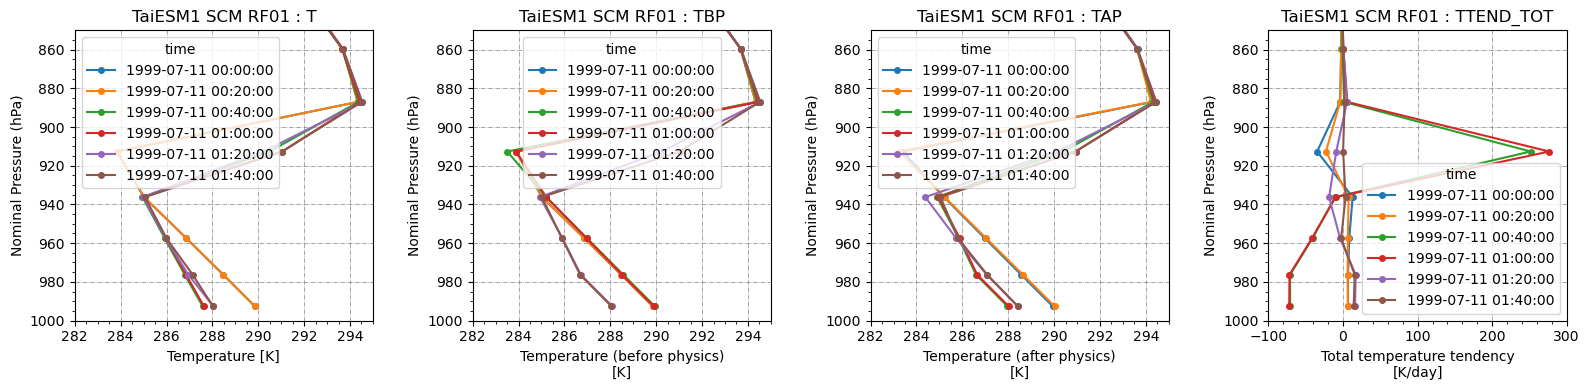

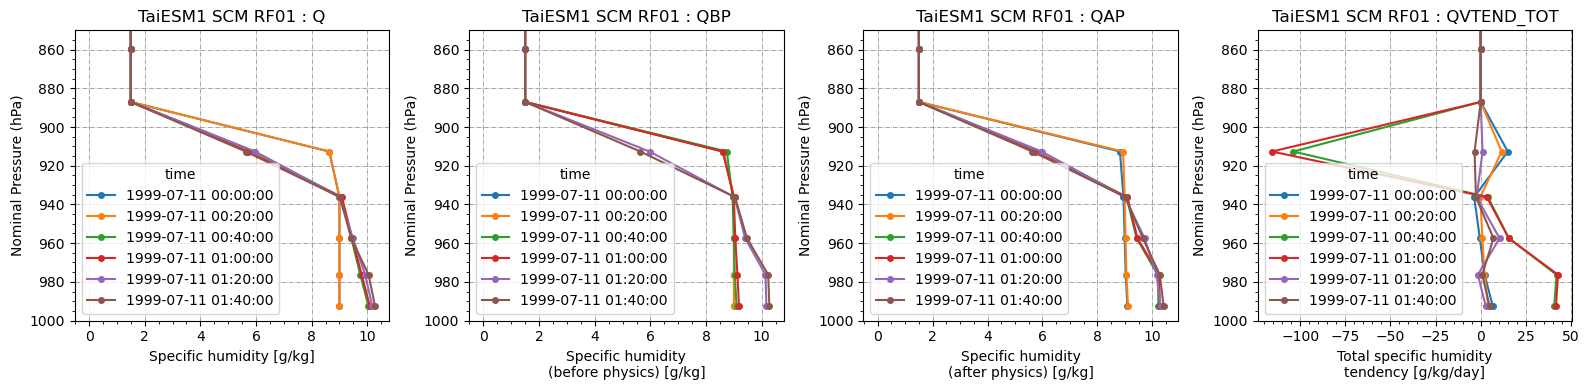

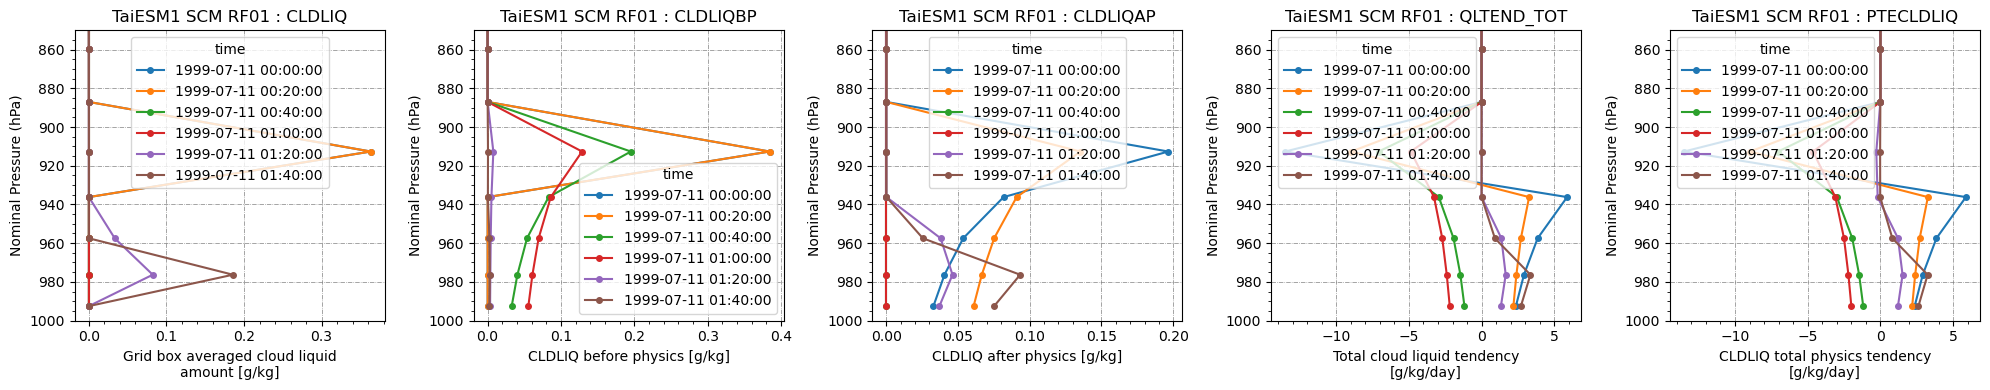

In [86]:
ttend_min=-100 ; ttend_max=300
tmin=282 ; tmax=295

xlim_custom = {
    "T": [tmin,tmax], "TBP": [tmin,tmax],  "TAP": [tmin,tmax], 
    "TTEND_TOT": [ttend_min, ttend_max], "MACPDT": [ttend_min, ttend_max], "MPDT": [ttend_min, ttend_max], "DTCORE": [ttend_min, ttend_max],
    
}
tt1=0
tt2=6
plot_scm_profiles_1vNt(ds_scm, ['T', 'TBP','TAP', 'TTEND_TOT', ], tt1=tt1, tt2=tt2, xlim=xlim_custom)
plot_scm_profiles_1vNt(ds_scm, ['Q', 'QBP','QAP', 'QVTEND_TOT', ], tt1=tt1, tt2=tt2, xlim=xlim_custom)
plot_scm_profiles_1vNt(ds_scm, ['CLDLIQ', 'CLDLIQBP','CLDLIQAP', 'QLTEND_TOT', 'PTECLDLIQ'], tt1=tt1, tt2=tt2, xlim=xlim_custom)


### nV1t: T, TBP, and TAP

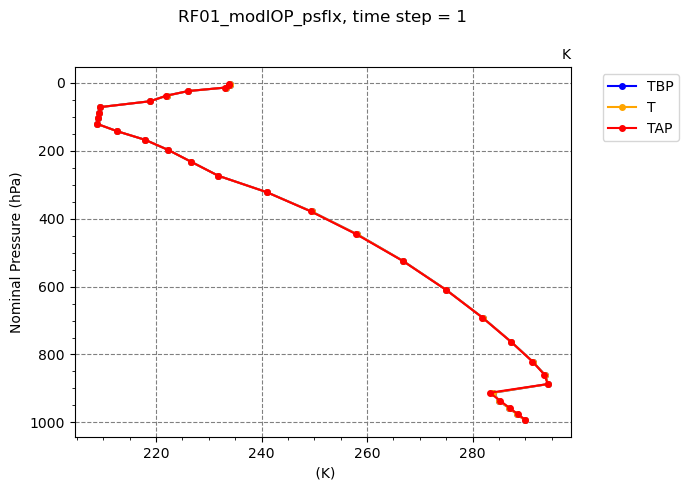

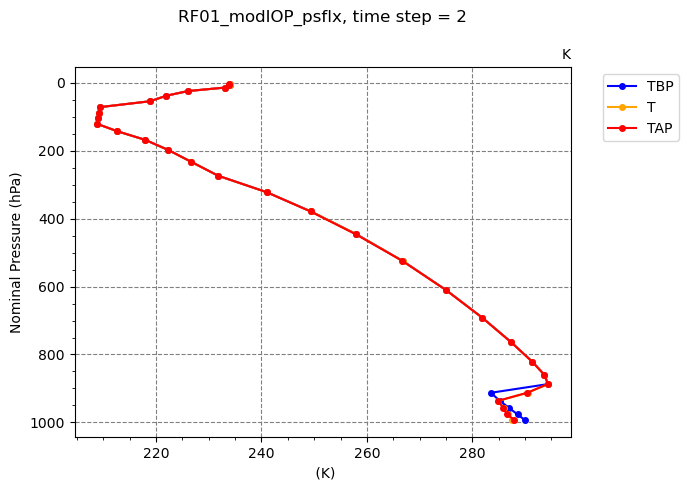

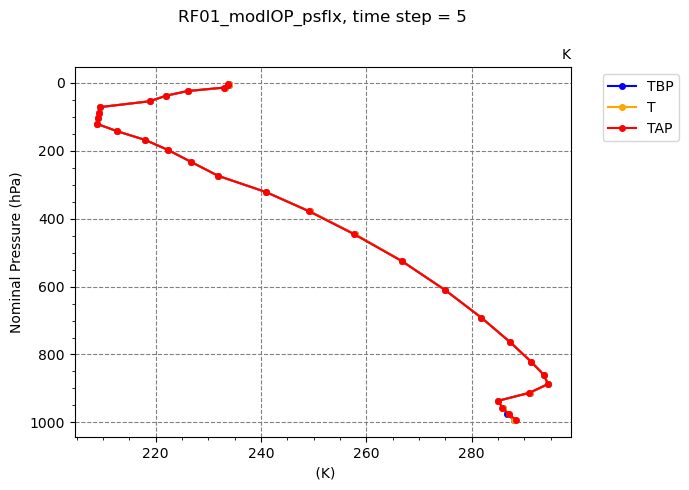

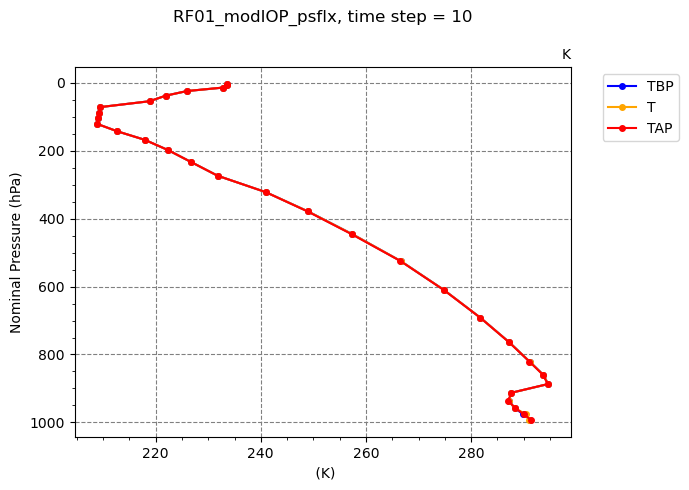

In [87]:
varnames = {
    'TBP': {'color': 'blue', 'linestyle': '-'},
    'T': {'color': 'orange', 'linestyle': '-'},
    'TAP': {'color': 'red', 'linestyle': '-'},
           }

tt_steps = [1, 2, 5, 10]

choice = "RF01_modIOP_psflx"
ds_scm = read_scm_ds(choice)

for tt in tt_steps:
    plot_scm_profiles_Nv1t (ds_scm, varnames, tt=tt, xlabel="", title=choice)

### T tendency

In [90]:
yhc.lib('np')


    #-------------
    # Numpy functions
    #-------------
    
    #--- create arrays  
    np.arange(0,3)             # create an array = [0,1,2,3]
    np.linspace(-10., 10., 5)  # create an array of 5 elements ranging from -10 to 10

    


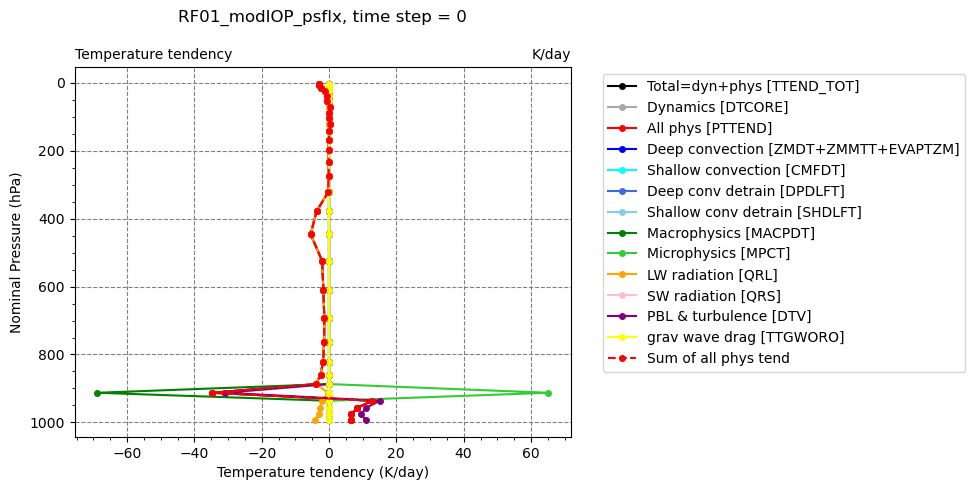

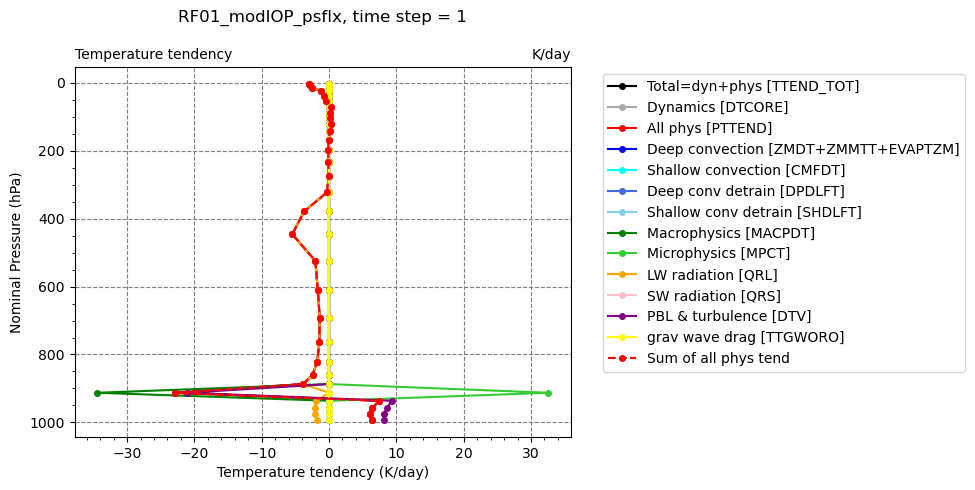

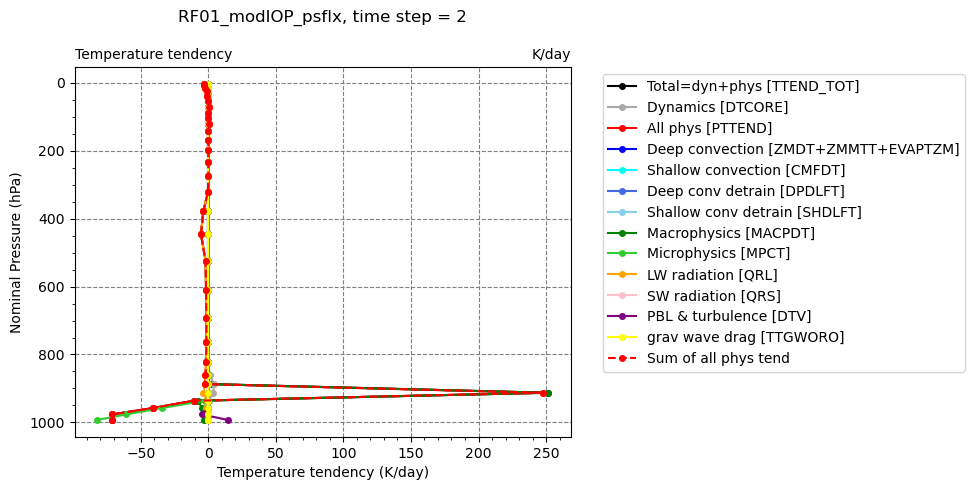

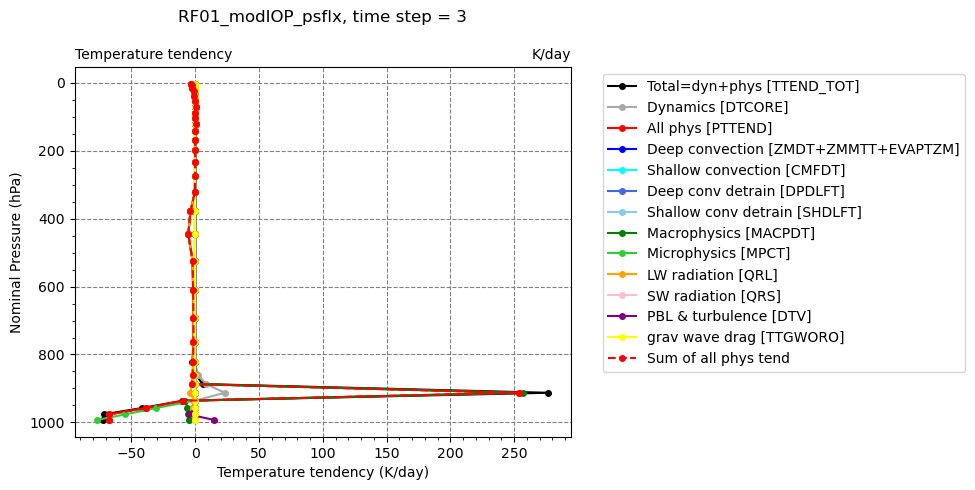

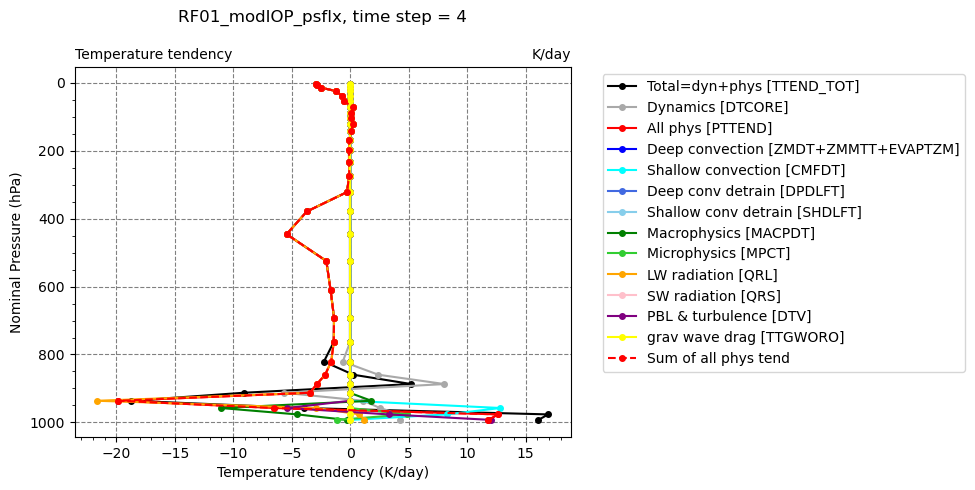

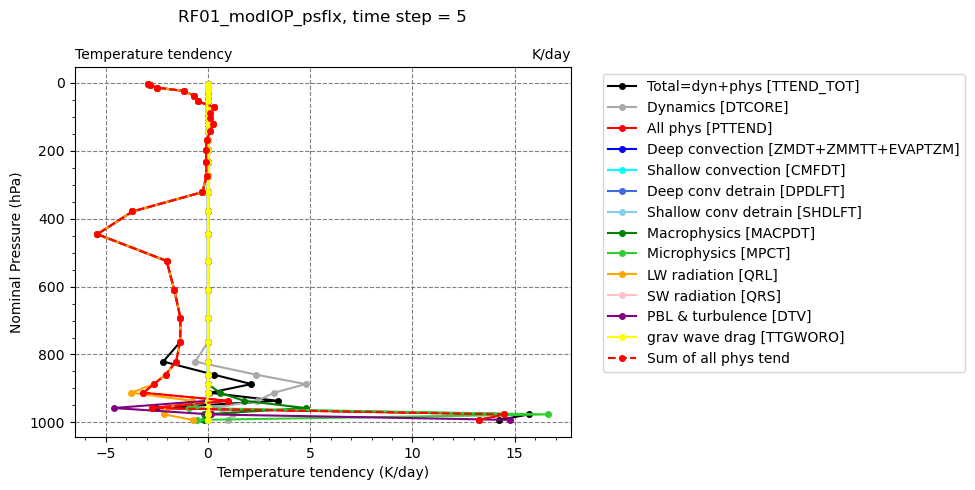

In [91]:
varnames = set_profile_varnames('DT_budget')

#tt_steps = [1, 2, 5, 10]
tt_steps = np.arange(0,6)

choice = "RF01_modIOP_psflx"
ds_scm = read_scm_ds(choice)

for tt in tt_steps:
    plot_scm_profiles_Nv1t (ds_scm, varnames, tt=tt, xlabel="Temperature tendency", title=choice)

### QV tendency

In [72]:
varnames = set_profile_varnames('DQV_budget')

### QL tendency

In [73]:
varnames = set_profile_varnames('DQL_budget')

### QI tendency

In [74]:
varnames = set_profile_varnames('DQI_budget')

## Print out variable profiles

In [75]:
#--- read SCM data
choice = "RF01_modIOP_psflx"
ds_scm = read_scm_ds(choice)

#--- variables
varnames_diag=["CLOUD",'CLDLIQ',"MACPDLIQ","MPDLIQ"]
ds_scm1 = yhc.diagnose_var(ds_scm, varnames_diag)

ds_name="ds_scm"
varnames = ['TBP','T','TAP',"TTEND_TOT"]
dim_name = "[tt,:,0,0]"
text_all = ', '.join([f"{ds_name}.{var}{dim_name}" for var in varnames])
print(text_all)

#--- given varnames_diag, I want to print them out
tt=0
yhc.print_1d_arrays(ds_scm.TBP[tt,:,0,0], ds_scm.TAP[tt,:,0,0], ds_scm.TTEND_TOT[tt,:,0,0], ds_scm.DTCORE[tt,:,0,0])

ds_scm.TBP[tt,:,0,0], ds_scm.T[tt,:,0,0], ds_scm.TAP[tt,:,0,0], ds_scm.TTEND_TOT[tt,:,0,0]
Index	lev	TBP	TAP	TTEND_TOT	DTCORE
1	3.64346569404006	234.0	233.9589385986328	-3.421822839300148e-05	0.0
2	7.594819646328688	234.0	233.96035766601562	-3.3037300454452634e-05	0.0
3	14.356632251292467	233.2023162841797	233.1671905517578	-2.9276781788212247e-05	0.0
4	24.612220004200935	226.12950134277344	226.11270141601562	-1.4004617696627975e-05	0.0
5	38.26829977333546	222.0059814453125	221.9962615966797	-8.10399797046557e-06	0.0
6	54.59547974169254	218.92538452148438	218.9180908203125	-6.075683813833166e-06	0.0
7	72.01245054602623	209.34767150878906	209.3515167236328	3.1974175271898275e-06	0.0
8	87.82123029232025	209.20156860351562	209.2028350830078	1.0484484391781734e-06	0.0
9	103.31712663173676	209.05836486816406	209.05979919433594	1.2049374618072761e-06	0.0
10	121.54724076390266	208.88987731933594	208.89312744140625	2.7050107291870518e-06	0.0
11	142.99403876066208	212.67398071289062	212.6753997